# Plot Error Simulation Results

Visualize experimental results from [`CompareWithDice`](CompareWithDice.ipynb) to determine relationships among error simulation parameters and various output metrics measuring differences between a warped and original label region.

In [1]:
import os
import sys
from typing import Tuple, List

import itk
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.typing as npt
import plotly.express as px
import scipy.stats

In [52]:
FILENAME = "simulation-results.03.03.23"
FILEDATE = ".".join(FILENAME.split(".")[1:])  # 02.23.23
FILEPATH = rf"data/dice_comparison/{FILENAME}.csv"
assert os.path.exists(FILEPATH)

In [53]:
sample_results = pd.read_csv(FILEPATH)
print(len(sample_results))
sample_results.tail()

6120


Unnamed: 0  label_value  grid_size  displacement_scale_mm  \
6115        6115          422          7                    0.5   
6116        6116          422          7                    0.5   
6117        6117          422          7                    0.5   
6118        6118          422          7                    0.5   
6119        6119          422          7                    0.5   

      n_point_samples  sampling_seed  output_dice  output_mean  output_stddev  \
6115              300              0     0.161583     0.133775       0.116330   
6116              300              1     0.161583     0.120022       0.112410   
6117              300              2     0.161583     0.125574       0.114621   
6118              300              3     0.161583     0.124772       0.115649   
6119              300              4     0.161583     0.122917       0.117941   

      output_median  
6115       0.132860  
6116       0.120075  
6117       0.124387  
6118       0.124048  
6119       0.116441

In [55]:
len(np.unique(sample_results["label_value"]))

17

In [56]:
sample_results["log10_displacement_scale_mm"] = np.log10(
    sample_results["displacement_scale_mm"]
)
sample_results["log10_label_value"] = np.log10(sample_results["label_value"])
sample_results["output_mean_plus_one"] = sample_results["output_mean"] + 1
sample_results["output_dice_plus_one"] = sample_results["output_dice"] + 1

C:\Users\tom.birdsong\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log10



In [57]:
# [sample_results['max_displacement_component_mm'] == 1.0]
results_df = sample_results[sample_results["n_point_samples"] > 0]
results_df["log10_n_point_samples"] = np.log10(results_df["n_point_samples"])
print(len(results_df))

6120


In [58]:
fig = px.scatter_matrix(results_df)
fig.show()

In [59]:
labels = {
    "output_mean": "Output Mean Point Displacement",
    "output_dice": "Output Dice Coefficient",
    "n_point_samples": "Number of Surface Points Sampled",
}

fig = px.scatter(
    results_df,
    x="output_mean",
    y="output_dice",
    color="n_point_samples",
    title=f"CCF Noise Simulation Results ({FILEDATE})",
    labels=labels,
)
fig.show()

## Fit Exponential Decay Function

In [60]:
# https://swharden.com/blog/2020-09-24-python-exponential-fit/


def monoExpZeroB(x, a, b):
    return a * np.exp(b * x)


def fit_decay(x0, x1, p0: Tuple = None) -> (float, float, npt.ArrayLike):
    if not p0:
        p0 = (1, 0.1)  # defaults for mean, dice
    params, cov = scipy.optimize.curve_fit(monoExpZeroB, x0, x1, p0)
    return params[0], params[1], cov


def discretize_decay(x: npt.ArrayLike, a: float, b: float) -> npt.ArrayLike:
    y = np.zeros(x.shape)
    for index, x_val in enumerate(x):
        y[index] = monoExpZeroB(x_val, a, b)
    return y

In [61]:
a, b, cov = fit_decay(results_df["output_mean"], results_df["output_dice"])

In [62]:
print(f"{a} {b} {cov}")

0.8838099293124718 -21.313230811789264 [[ 7.44666915e-06 -2.23966047e-04]
 [-2.23966047e-04  5.17282902e-02]]


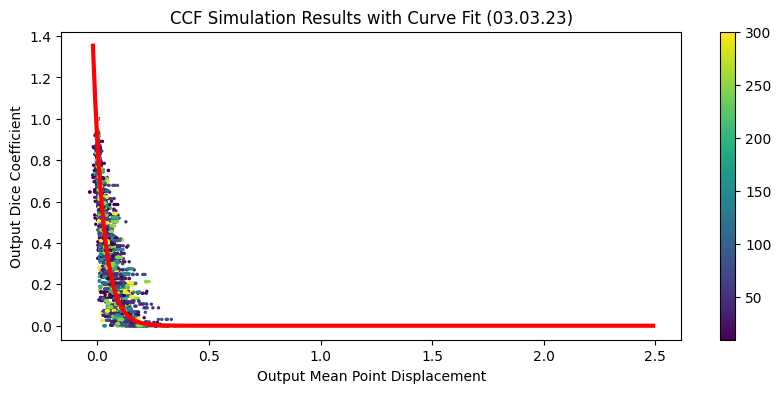

In [63]:
plt.figure(figsize=(10, 4))
plt.scatter(
    results_df["output_mean"],
    results_df["output_dice"],
    s=2,
    c=results_df["n_point_samples"],
)

x = np.arange(-0.02, 2.5, 0.01)
plt.plot(x, discretize_decay(x, a, b), linewidth=3, color="red")

plt.title(f"CCF Simulation Results with Curve Fit ({FILEDATE})")
plt.xlabel(labels["output_mean"])
plt.ylabel(labels["output_dice"])

plt.colorbar()
plt.show()

## TODO: Compare with Shape Features

In [64]:
label_image = itk.imread(
    r"data\CCFv31\annotation_25.nii.gz", pixel_type=itk.US
)

# Preprocessing: Crop to a single CCFv31 hemisphere to avoid confounding shape statistics with
# mirrored, disconnected regions

CROP_AXIS = 2

upper_crop_size = [
    int(itk.size(label_image)[dim] / 2) if dim == 2 else 0
    for dim, side_len in enumerate(itk.size(label_image))
]

cropped_label_image = itk.crop_image_filter(
    label_image,
    upper_boundary_crop_size=upper_crop_size,
    lower_boundary_crop_size=[0] * 3,
)

In [65]:
shape_label_image = itk.label_image_to_shape_label_map_filter(
    cropped_label_image, compute_perimeter=True, compute_feret_diameter=False
)

In [66]:
label_values = np.unique(np.array(sample_results.loc[:, "label_value"]))

shape_headers = [
    "region_index",
    "label_value",
    "n_pixels",
    "bounding_box",
    "physical_size",
    "log10_physical_size",
    "perimeter",
    "elongation",
    "flatness",
    "roundness",
    "equivalent_spherical_radius",
    "equivalent_spherical_perimeter",
]
shape_df = pd.DataFrame(columns=shape_headers)

for region_index in range(shape_label_image.GetNumberOfLabelObjects()):
    region = shape_label_image.GetNthLabelObject(region_index)
    label_value = region.GetLabel()
    shape_row = pd.DataFrame(
        [
            [
                region_index,
                label_value,
                region.GetNumberOfPixels(),
                region.GetBoundingBox(),
                region.GetPhysicalSize(),
                np.log10(region.GetPhysicalSize()),
                region.GetPerimeter(),
                region.GetElongation(),
                region.GetFlatness(),
                region.GetRoundness(),
                region.GetEquivalentSphericalRadius(),
                region.GetEquivalentSphericalPerimeter(),
            ]
        ],
        columns=shape_headers,
    )
    shape_df = pd.concat([shape_df, shape_row], ignore_index=True)

print(len(shape_df))
shape_df.head()

669


region_index label_value n_pixels  \
0            0           1     3468   
1            1           2     3669   
2            2           6    67198   
3            3           7    35045   
4            4           9     7438   

                                      bounding_box  physical_size  \
0   itkImageRegion3([294, 256, 175], [17, 24, 29])       0.054188   
1    itkImageRegion3([171, 106, 91], [58, 61, 42])       0.057328   
2  itkImageRegion3([205, 129, 94], [103, 114, 86])       1.049969   
3   itkImageRegion3([380, 190, 131], [46, 71, 27])       0.547578   
4    itkImageRegion3([252, 43, 130], [38, 22, 56])       0.116219   

   log10_physical_size  perimeter  elongation  flatness  roundness  \
0            -1.266101   0.864059    1.907659  1.774334   0.801444   
1            -1.241632   3.393600    1.252242  8.241323   0.211870   
2             0.021176  13.487530    1.372371  3.779856   0.370399   
3            -0.261554   4.401996    1.496542  2.328088   0.735301   
4            -0.934724   1.885113    3.371243  1.871303   0.610938   

   equivalent_spherical_radius  equivalent_spherical_perimeter  
0                     0.234749                        0.692495  
1                     0.239199                        0.719001  
2                     0.630516                        4.995762  
3                     0.507519                        3.236793  
4                     0.302735                        1.151688

In [67]:
shape_results = pd.merge(
    sample_results, shape_df, on="label_value", how="inner"
)
assert len(shape_results) == len(sample_results)
shape_results.head()

Unnamed: 0 label_value  grid_size  displacement_scale_mm  n_point_samples  \
0           0         461          7                    0.0               10   
1           1         461          7                    0.0               10   
2           2         461          7                    0.0               10   
3           3         461          7                    0.0               10   
4           4         461          7                    0.0               10   

   sampling_seed  output_dice  output_mean  output_stddev  output_median  ...  \
0              0          1.0    -0.000193       0.000202  -1.275752e-04  ...   
1              1          1.0    -0.000243       0.000179  -2.673298e-04  ...   
2              2          1.0    -0.000123       0.000155   2.753063e-09  ...   
3              3          1.0    -0.000184       0.000234   2.966013e-09  ...   
4              4          1.0    -0.000184       0.000234   1.946709e-09  ...   

   n_pixels                                   bounding_box  physical_size  \
0      1100  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
1      1100  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
2      1100  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
3      1100  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
4      1100  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   

   log10_physical_size perimeter elongation  flatness  roundness  \
0            -1.764787   1.08091   3.363501  5.759558   0.297968   
1            -1.764787   1.08091   3.363501  5.759558   0.297968   
2            -1.764787   1.08091   3.363501  5.759558   0.297968   
3            -1.764787   1.08091   3.363501  5.759558   0.297968   
4            -1.764787   1.08091   3.363501  5.759558   0.297968   

   equivalent_spherical_radius  equivalent_spherical_perimeter  
0                     0.160094                        0.322077  
1                     0.160094                        0.322077  
2                     0.160094                        0.322077  
3                     0.160094                        0.322077  
4                     0.160094                        0.322077  

[5 rows x 25 columns]

In [68]:
shape_results_filtered = shape_results[
    shape_results["displacement_scale_mm"] < 1.0
]
shape_results_filtered.shape

(6120, 25)

In [69]:
labels["label_value"] = "CCF Label Value"

fig = px.scatter(
    shape_results_filtered,
    x="output_mean",
    y="output_dice",
    color="label_value",
    title=f"CCF Noise Simulation Results ({FILEDATE})",
    labels=labels,
)
fig.show()

In [70]:
fig = px.scatter(
    shape_results_filtered,
    x="log10_physical_size",
    y="output_dice",
    color="log10_displacement_scale_mm",
    title=f"CCF Noise Simulation Results ({FILEDATE})",
)
fig.show()

In [71]:
label_subset = np.random.choice(
    np.unique(shape_results_filtered["label_value"]), size=2, replace=False
)
fig = px.scatter(
    shape_results_filtered[
        shape_results_filtered["label_value"].isin(label_subset)
    ],
    x="displacement_scale_mm",
    y="output_dice",
    facet_row="label_value",
    trendline="ols",
    height=1400,
)
fig.show()

## TODO: Quantify relationship between Dice and Mean

In [72]:
shape_results_filtered = shape_results[
    shape_results["displacement_scale_mm"] < 1.0
]

In [73]:
# Get unique boundary sample point counts with at least 100 experiment entries
MIN_POINTS = 1
MIN_ENTRIES = 100

unique_point_vals, unique_point_vals_freq = np.unique(
    shape_results_filtered["n_point_samples"], return_counts=True
)
for val, freq in zip(unique_point_vals, unique_point_vals_freq):
    print(f"{val}: {freq}")

n_point_samples_filtered = [
    val
    for val, freq in zip(unique_point_vals, unique_point_vals_freq)
    if val > MIN_POINTS and freq > MIN_ENTRIES
]

10: 680
30: 680
50: 680
75: 680
100: 680
150: 680
200: 680
250: 680
300: 680


In [74]:
shape_results_filtered = shape_results_filtered[
    shape_results_filtered["n_point_samples"].isin(n_point_samples_filtered)
]

In [75]:
fig = px.scatter(
    shape_results_filtered,
    x="output_mean",
    y="output_dice",
    facet_row="n_point_samples",
    trendline="ols",
    height=1400,
)
fig.show()

In [76]:
# Compute linear correlation for each discrete category of point samples

r2_vals = list()

for n_surface_points in n_point_samples_filtered:

    df = shape_results_filtered[
        shape_results_filtered["n_point_samples"] == n_surface_points
    ]
    linregress_result = scipy.stats.linregress(
        df["output_mean"], df["output_dice"]
    )
    r2_vals.append(linregress_result.rvalue**2)
    print(f"{n_surface_points} points -> R^2 == {r2_vals[-1]}")

10 points -> R^2 == 0.5725935667140004
30 points -> R^2 == 0.6176633710582987
50 points -> R^2 == 0.5983471719948594
75 points -> R^2 == 0.5542935382640162
100 points -> R^2 == 0.6768251347645805
150 points -> R^2 == 0.6900027476043974
200 points -> R^2 == 0.691687405953755
250 points -> R^2 == 0.6499778147703951
300 points -> R^2 == 0.5974922349492249


In [77]:
r2_df = pd.DataFrame(
    np.transpose([n_point_samples_filtered, r2_vals]),
    columns=["n_point_samples", "R^2"],
)
labels = {
    "n_point_samples": "Number of Label Region Boundary Points Sampled",
    "R^2": "R^2 (Dice and Mean Point Displacement)",
}

px.scatter(
    r2_df,
    x="n_point_samples",
    y="R^2",
    labels=labels,
    title=f"Difference Metric Correlation versus Number of Boundary Point Samples ({FILEDATE})",
    trendline="ols",
    trendline_options=dict(log_x=True),
)

In [78]:
n_points_r2_regression = scipy.stats.linregress(
    [np.log(x) for x in n_point_samples_filtered], r2_vals
)
print(n_points_r2_regression)

LinregressResult(slope=0.024214331229329707, intercept=0.5198389252936158, rvalue=0.5206949846309707, pvalue=0.15064122634265892, stderr=0.015006074830711905, intercept_stderr=0.06862453009237442)


## Fit Exponential Decay by # points sampled

In [79]:
decay_fit_dict = dict()
for n_point_samples in n_point_samples_filtered:
    df_tmp = shape_results_filtered[
        shape_results_filtered["n_point_samples"] == n_point_samples
    ]
    decay_fit_dict[n_point_samples] = fit_decay(
        df_tmp["output_mean"], df_tmp["output_dice"]
    )

print(decay_fit_dict)

{10: (0.8269722826387953, -16.137725637813553, array([[ 8.27993157e-05, -1.60157323e-03],
       [-1.60157323e-03,  3.92234393e-01]])), 30: (0.8670953505858914, -20.39073520047336, array([[ 7.58458973e-05, -2.11588019e-03],
       [-2.11588019e-03,  5.24918916e-01]])), 50: (0.8947605335061607, -22.052574583496565, array([[ 6.24116844e-05, -2.24172917e-03],
       [-2.24172917e-03,  4.73435907e-01]])), 75: (0.9120380845362341, -25.37882849256082, array([[ 6.52031331e-05, -2.48495253e-03],
       [-2.48495253e-03,  5.93333976e-01]])), 100: (0.9029081370948614, -22.645852401375283, array([[ 5.50010897e-05, -1.84233302e-03],
       [-1.84233302e-03,  4.21671352e-01]])), 150: (0.9016527622127882, -24.027316599764696, array([[ 6.18407613e-05, -2.29648437e-03],
       [-2.29648437e-03,  5.45473900e-01]])), 200: (0.9063653924749686, -23.50532595069124, array([[ 5.67471974e-05, -2.11872511e-03],
       [-2.11872511e-03,  4.73360214e-01]])), 250: (0.892018293989053, -20.60010567531648, array([[ 

In [80]:
def plot_decay(ax, filtered_df, decay_terms, color="red"):
    DECAY_STEP = 0.005
    x = np.arange(
        np.min(filtered_df["output_mean"]),
        np.max(filtered_df["output_mean"]) + DECAY_STEP,
        DECAY_STEP,
    )
    y = discretize_decay(x, decay_terms[0], decay_terms[1])
    ax.plot(x, y, linewidth=3, color=color)


def scatter_decay(
    ax, filtered_df, decay_terms, point_color="blue", fit_color="red"
):
    ax.scatter(
        filtered_df["output_mean"],
        filtered_df["output_dice"],
        s=2,
        color=point_color,
    )

    plot_decay(ax, filtered_df, decay_terms, fit_color)

0: 10
1: 30
2: 50
3: 75
4: 100
5: 150
6: 200
7: 250
8: 300


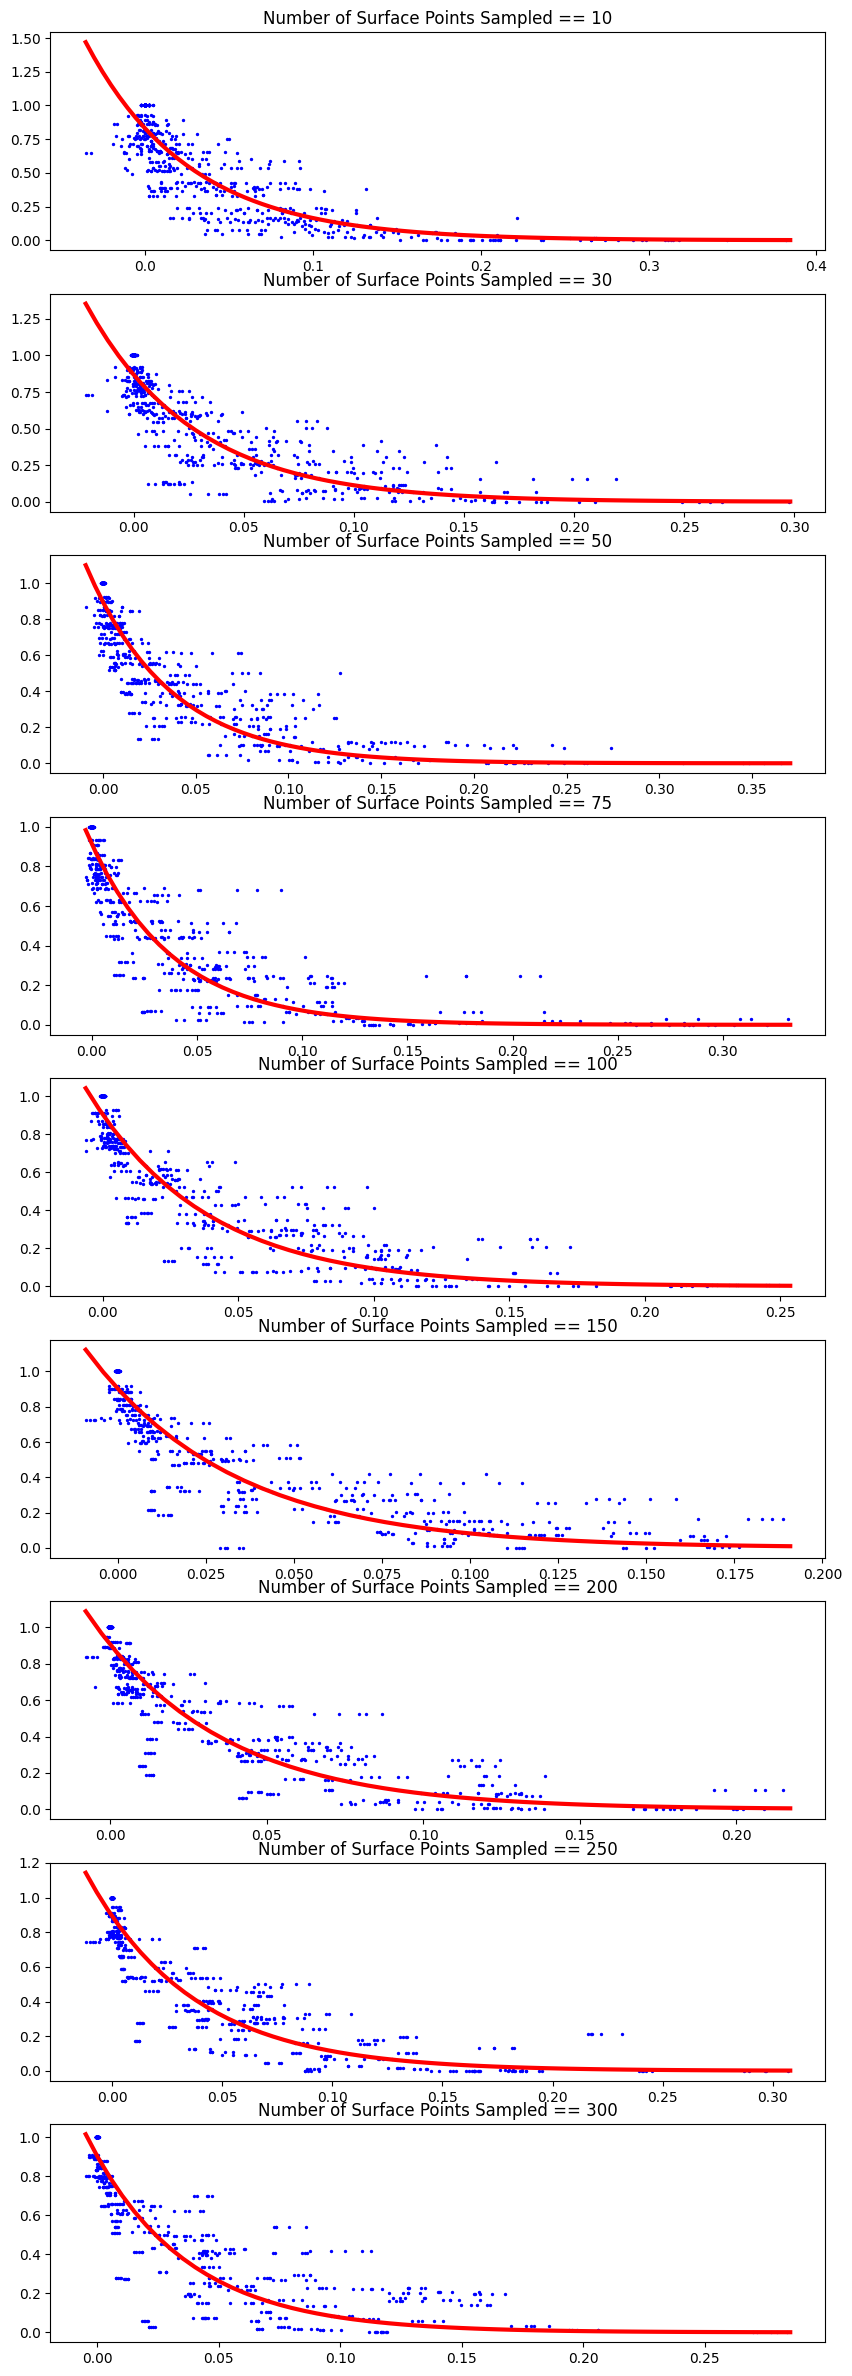

In [81]:
fig, axs = plt.subplots(len(n_point_samples_filtered), figsize=(10, 30))

for idx, n_point_samples in enumerate(n_point_samples_filtered):
    print(f"{idx}: {n_point_samples}")
    df_tmp = shape_results_filtered[
        shape_results_filtered["n_point_samples"] == n_point_samples
    ]
    scatter_decay(axs[idx], df_tmp, decay_fit_dict[n_point_samples])
    axs[idx].set_title(
        f"Number of Surface Points Sampled == {n_point_samples}"
    )

plt.show()

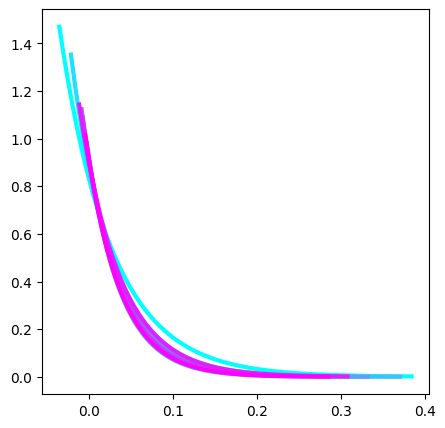

In [82]:
fig, axs = plt.subplots(1, figsize=(5, 5))

c = plt.cm.cool(np.linspace(0, 1, len(n_point_samples_filtered)))
for idx, n_point_samples in enumerate(n_point_samples_filtered):
    df_tmp = shape_results_filtered[
        shape_results_filtered["n_point_samples"] == n_point_samples
    ]
    plot_decay(axs, df_tmp, decay_fit_dict[n_point_samples], color=c[idx])

plt.show()

In [83]:
def estimate_decay_sum_of_squares(filtered_df, decay_params):
    x = filtered_df["output_mean"]
    y = filtered_df["output_dice"]
    y_hat = discretize_decay(x, decay_params[0], decay_params[1])
    return np.sum((y - y_hat) ** 2)

In [84]:
# Estimate standard deviation of the residual as a measure of goodness of fit for each sample distribution

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2892436/
# https://www.graphpad.com/support/faq/standard-deviation-of-the-residuals-syx-rmse-rsdr/
# https://blog.minitab.com/en/adventures-in-statistics-2/why-is-there-no-r-squared-for-nonlinear-regression


decay_ssq_columns = [
    "n_point_samples",
    "n_entries",
    "sum_of_squares",
    "avg_sq_residual",
    "stddev_residual",
]
sum_of_squares_df = pd.DataFrame(columns=decay_ssq_columns)

for n_point_samples in n_point_samples_filtered:
    df_tmp = shape_results_filtered[
        shape_results_filtered["n_point_samples"] == n_point_samples
    ]
    ssq = estimate_decay_sum_of_squares(
        df_tmp, decay_fit_dict[n_point_samples]
    )

    result = pd.DataFrame(
        [
            [
                n_point_samples,
                len(df_tmp),
                ssq,
                ssq / len(df_tmp),
                np.sqrt(ssq / (len(df_tmp) - 2)),
            ]
        ],
        columns=decay_ssq_columns,
    )
    sum_of_squares_df = pd.concat(
        [sum_of_squares_df, result], ignore_index=True
    )

print(sum_of_squares_df)

  n_point_samples n_entries  sum_of_squares  avg_sq_residual  stddev_residual
0              10       680       21.250338         0.031250         0.177039
1              30       680       17.655221         0.025964         0.161370
2              50       680       12.669032         0.018631         0.136696
3              75       680       12.920125         0.019000         0.138044
4             100       680       11.363995         0.016712         0.129464
5             150       680       12.493890         0.018373         0.135748
6             200       680       11.648794         0.017131         0.131077
7             250       680       12.615977         0.018553         0.136410
8             300       680       14.862221         0.021856         0.148056


In [85]:
# r2_df = pd.DataFrame(np.transpose([n_point_samples_filtered, r2_vals]),
#                     columns=['n_point_samples','R^2'])
labels = {
    "n_point_samples": "Number of Label Region Boundary Points Sampled",
    "sum_of_squares": "Sum of Squares for Predicted Dice Metric from Mean Displacement",
    "avg_sq_residual": "Mean Squared Residual, Predicted vs Expected Dice",
    "stddev_residual": "Standard Deviation of the Residual",
}

px.line(
    sum_of_squares_df,
    x="n_point_samples",
    y="stddev_residual",
    labels=labels,
    title=f"Regression Fitness by Number of Surface Points Sampled ({FILEDATE})",
)
# trendline='ols',trendline_options=dict(log_x=True))

## Break Down Correlation by Physical Size

In [86]:
num_labels = len(np.unique(shape_results_filtered["label_value"]))

physical_sizes = np.unique(shape_results_filtered["physical_size"])
print(physical_sizes)
assert len(physical_sizes) == num_labels

[0.00304688 0.0171875  0.01770313 0.02475    0.03085938 0.04370313
 0.04784375 0.05109375 0.05670313 0.06725    0.104      0.15328126
 0.17165626 0.19434376 0.26578126 0.35167189 1.43795319]


In [101]:
PERCENTILE_STEP = 20
physical_size_bins = np.array(
    [
        np.percentile(physical_sizes, p)
        for p in np.arange(PERCENTILE_STEP, 101, PERCENTILE_STEP)
    ]
)
print(physical_size_bins)

[0.02597188 0.04914375 0.0893     0.18980626 1.43795319]


In [102]:
import tqdm

shape_results_filtered["physical_size_percentile"] = -1  # initialize
for index in tqdm.tqdm(shape_results_filtered["physical_size"].index):

    shape_results_filtered.loc[
        index, "physical_size_percentile"
    ] = PERCENTILE_STEP * (
        np.argmax(
            physical_size_bins
            >= shape_results_filtered.loc[index, "physical_size"]
        )
        + 1
    )

100%|████████████████████████████████████████████████████████████████████████████| 6120/6120 [00:01<00:00, 4053.15it/s]


In [103]:
shape_results_filtered.head()

Unnamed: 0 label_value  grid_size  displacement_scale_mm  n_point_samples  \
0           0         461          7                    0.0               10   
1           1         461          7                    0.0               10   
2           2         461          7                    0.0               10   
3           3         461          7                    0.0               10   
4           4         461          7                    0.0               10   

   sampling_seed  output_dice  output_mean  output_stddev  output_median  ...  \
0              0          1.0    -0.000193       0.000202  -1.275752e-04  ...   
1              1          1.0    -0.000243       0.000179  -2.673298e-04  ...   
2              2          1.0    -0.000123       0.000155   2.753063e-09  ...   
3              3          1.0    -0.000184       0.000234   2.966013e-09  ...   
4              4          1.0    -0.000184       0.000234   1.946709e-09  ...   

                                    bounding_box  physical_size  \
0  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
1  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
2  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
3  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
4  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   

   log10_physical_size  perimeter elongation  flatness roundness  \
0            -1.764787    1.08091   3.363501  5.759558  0.297968   
1            -1.764787    1.08091   3.363501  5.759558  0.297968   
2            -1.764787    1.08091   3.363501  5.759558  0.297968   
3            -1.764787    1.08091   3.363501  5.759558  0.297968   
4            -1.764787    1.08091   3.363501  5.759558  0.297968   

   equivalent_spherical_radius  equivalent_spherical_perimeter  \
0                     0.160094                        0.322077   
1                     0.160094                        0.322077   
2                     0.160094                        0.322077   
3                     0.160094                        0.322077   
4                     0.160094                        0.322077   

   physical_size_percentile  
0                        20  
1                        20  
2                        20  
3                        20  
4                        20  

[5 rows x 26 columns]

In [104]:
# Compute linear correlation for each discrete category of point samples

r2_headers = [
    "n_point_samples",
    "phys_size_bin_index",
    "percentile",
    "min_phys_size",
    "max_phys_size",
    "bin_count",
    "R^2",
]
r2_vals_phys_size_df = pd.DataFrame(columns=r2_headers)

for n_surface_points in n_point_samples_filtered:
    for bin_index in range(len(physical_size_bins)):
        bin_min = physical_size_bins[bin_index - 1] if bin_index > 0 else 0
        bin_max = physical_size_bins[bin_index]

        df = shape_results_filtered[
            shape_results_filtered["n_point_samples"] == n_surface_points
        ]
        df = df[df["physical_size"] > bin_min]
        df = df[df["physical_size"] <= bin_max]

        linregress_result = scipy.stats.linregress(
            df["output_mean"], df["output_dice"]
        )

        r2_row = pd.DataFrame(
            [
                [
                    n_surface_points,
                    bin_index,
                    PERCENTILE_STEP * (bin_index + 1),
                    bin_min,
                    bin_max,
                    len(df),
                    linregress_result.rvalue**2,
                ]
            ],
            columns=r2_headers,
        )

        r2_vals_phys_size_df = pd.concat(
            [r2_vals_phys_size_df, r2_row], ignore_index=True
        )

In [105]:
r2_vals_phys_size_df

n_point_samples phys_size_bin_index percentile min_phys_size  \
0               10                   0         20             0   
1               10                   1         40      0.025972   
2               10                   2         60      0.049144   
3               10                   3         80        0.0893   
4               10                   4        100      0.189806   
5               30                   0         20             0   
6               30                   1         40      0.025972   
7               30                   2         60      0.049144   
8               30                   3         80        0.0893   
9               30                   4        100      0.189806   
10              50                   0         20             0   
11              50                   1         40      0.025972   
12              50                   2         60      0.049144   
13              50                   3         80        0.0893   
14              50                   4        100      0.189806   
15              75                   0         20             0   
16              75                   1         40      0.025972   
17              75                   2         60      0.049144   
18              75                   3         80        0.0893   
19              75                   4        100      0.189806   
20             100                   0         20             0   
21             100                   1         40      0.025972   
22             100                   2         60      0.049144   
23             100                   3         80        0.0893   
24             100                   4        100      0.189806   
25             150                   0         20             0   
26             150                   1         40      0.025972   
27             150                   2         60      0.049144   
28             150                   3         80        0.0893   
29             150                   4        100      0.189806   
30             200                   0         20             0   
31             200                   1         40      0.025972   
32             200                   2         60      0.049144   
33             200                   3         80        0.0893   
34             200                   4        100      0.189806   
35             250                   0         20             0   
36             250                   1         40      0.025972   
37             250                   2         60      0.049144   
38             250                   3         80        0.0893   
39             250                   4        100      0.189806   
40             300                   0         20             0   
41             300                   1         40      0.025972   
42             300                   2         60      0.049144   
43             300                   3         80        0.0893   
44             300                   4        100      0.189806   

    max_phys_size bin_count       R^2  
0        0.025972       160  0.481331  
1        0.049144       120  0.643156  
2        0.089300       120  0.665832  
3        0.189806       120  0.733765  
4        1.437953       160  0.573381  
5        0.025972       160  0.509135  
6        0.049144       120  0.635028  
7        0.089300       120  0.793048  
8        0.189806       120  0.697879  
9        1.437953       160  0.682552  
10       0.025972       160  0.561419  
11       0.049144       120  0.661153  
12       0.089300       120  0.665149  
13       0.189806       120  0.830866  
14       1.437953       160  0.646681  
15       0.025972       160  0.413152  
16       0.049144       120  0.725668  
17       0.089300       120  0.578795  
18       0.189806       120  0.691530  
19       1.437953       160  0.663479  
20       0.025972       160  0.517966  
21       0.049144       120  0.719174  


In [106]:
labels["n_point_samples"] = "Number of Label Region Boundary Points Sampled"
labels["R^2"] = "R^2 (Dice and Mean Point Displacement)"

px.scatter(
    r2_vals_phys_size_df,
    x="n_point_samples",
    y="R^2",
    labels=labels,
    color="percentile",
    title=f"Difference Metric Correlation versus Number of Boundary Point Samples ({FILEDATE})",
    trendline="ols",
    trendline_options=dict(log_x=True),
)

In [107]:
# label_value = np.random.choice(np.unique(shape_results_filtered['label_value']))
# shape_results_filtered[shape_results_filtered['label_value'] == label_value].head()

In [108]:
# View scatter for strongest correlation for each quartile

fig = px.scatter(
    shape_results_filtered[shape_results_filtered["n_point_samples"] == 300],
    #             shape_results_filtered[shape_results_filtered['label_value'] == label_value],
    x="output_mean",
    y="output_dice",
    facet_row="physical_size_percentile",
    category_orders={
        "physical_size_percentile": np.arange(
            PERCENTILE_STEP, 101, PERCENTILE_STEP
        )
    },
    color="displacement_scale_mm",
    color_continuous_scale="turbo",
    trendline="ols",
    height=1400,
)
fig.show()

## TODO exponential fit

In [109]:
decay_fit_by_size = dict()
for n_point_samples in n_point_samples_filtered:
    df_tmp = shape_results_filtered[
        shape_results_filtered["n_point_samples"] == n_point_samples
    ]
    decay_fit_dict[n_point_samples] = fit_decay(
        df_tmp["output_mean"], df_tmp["output_dice"]
    )

print(decay_fit_dict)

{10: (0.8269722826387953, -16.137725637813553, array([[ 8.27993157e-05, -1.60157323e-03],
       [-1.60157323e-03,  3.92234393e-01]])), 30: (0.8670953505858914, -20.39073520047336, array([[ 7.58458973e-05, -2.11588019e-03],
       [-2.11588019e-03,  5.24918916e-01]])), 50: (0.8947605335061607, -22.052574583496565, array([[ 6.24116844e-05, -2.24172917e-03],
       [-2.24172917e-03,  4.73435907e-01]])), 75: (0.9120380845362341, -25.37882849256082, array([[ 6.52031331e-05, -2.48495253e-03],
       [-2.48495253e-03,  5.93333976e-01]])), 100: (0.9029081370948614, -22.645852401375283, array([[ 5.50010897e-05, -1.84233302e-03],
       [-1.84233302e-03,  4.21671352e-01]])), 150: (0.9016527622127882, -24.027316599764696, array([[ 6.18407613e-05, -2.29648437e-03],
       [-2.29648437e-03,  5.45473900e-01]])), 200: (0.9063653924749686, -23.50532595069124, array([[ 5.67471974e-05, -2.11872511e-03],
       [-2.11872511e-03,  4.73360214e-01]])), 250: (0.892018293989053, -20.60010567531648, array([[ 

In [110]:
# Estimate sum of squares as a measure of goodness of fit for each sample distribution

decay_ssq_columns = ["n_point_samples", "sum_of_squares"]
sum_of_squares_df = pd.DataFrame(columns=decay_ssq_columns)

for n_point_samples in n_point_samples_filtered:
    df_tmp = shape_results_filtered[
        shape_results_filtered["n_point_samples"] == n_point_samples
    ]
    ssq = estimate_decay_sum_of_squares(
        df_tmp, decay_fit_dict[n_point_samples]
    )

    result = pd.DataFrame([[n_point_samples, ssq]], columns=decay_ssq_columns)
    sum_of_squares_df = pd.concat(
        [sum_of_squares_df, result], ignore_index=True
    )

print(sum_of_squares_df)

  n_point_samples  sum_of_squares
0              10       21.250338
1              30       17.655221
2              50       12.669032
3              75       12.920125
4             100       11.363995
5             150       12.493890
6             200       11.648794
7             250       12.615977
8             300       14.862221


In [111]:
# Compute nonlinear correlation for each discrete category of point samples

ssq_headers = [
    "n_point_samples",
    "phys_size_bin_index",
    "percentile",
    "min_phys_size",
    "max_phys_size",
    "bin_count",
    "sum_of_squares",
    "avg_sq_residual",
    "stddev_residual",
]
ssq_vals_phys_size_df = pd.DataFrame(columns=ssq_headers)

for n_point_samples in n_point_samples_filtered:
    for bin_index in range(len(physical_size_bins)):
        bin_min = physical_size_bins[bin_index - 1] if bin_index > 0 else 0
        bin_max = physical_size_bins[bin_index]

        df = shape_results_filtered[
            shape_results_filtered["n_point_samples"] == n_point_samples
        ]
        df = df[df["physical_size"] > bin_min]
        df = df[df["physical_size"] <= bin_max]

        decay_params = fit_decay(df["output_mean"], df["output_dice"])
        ssq = estimate_decay_sum_of_squares(df, decay_params)
        ssq_row = pd.DataFrame(
            [
                [
                    n_point_samples,
                    bin_index,
                    PERCENTILE_STEP * (bin_index + 1),
                    bin_min,
                    bin_max,
                    len(df),
                    ssq,
                    ssq / len(df),
                    np.sqrt(ssq / (len(df) - 2)),
                ]
            ],
            columns=ssq_headers,
        )

        ssq_vals_phys_size_df = pd.concat(
            [ssq_vals_phys_size_df, ssq_row], ignore_index=True
        )

ssq_vals_phys_size_df.head()

n_point_samples phys_size_bin_index percentile min_phys_size  max_phys_size  \
0              10                   0         20             0       0.025972   
1              10                   1         40      0.025972       0.049144   
2              10                   2         60      0.049144       0.089300   
3              10                   3         80        0.0893       0.189806   
4              10                   4        100      0.189806       1.437953   

  bin_count  sum_of_squares  avg_sq_residual  stddev_residual  
0       160        2.411557         0.015072         0.123544  
1       120        2.883005         0.024025         0.156308  
2       120        1.587453         0.013229         0.115987  
3       120        2.649850         0.022082         0.149854  
4       160        4.679630         0.029248         0.172099

In [112]:
# labels = {
#    'n_point_samples': 'Number of Label Region Boundary Points Sampled',
#    'R^2': 'R^2 (Dice and Mean Point Displacement)'
# }
labels["percentile"] = "Physical size %"

px.line(
    ssq_vals_phys_size_df,
    x="n_point_samples",
    y="stddev_residual",
    color="percentile",
    labels=labels,
    title=f"Regression Fitness by Physical Size {FILEDATE}",
)
# title=f'Difference Metric Correlation versus Number of Boundary Point Samples ({FILEDATE})',
# trendline='ols',trendline_options=dict(log_x=True))

In [113]:
df_tmp = shape_results_filtered[
    shape_results_filtered["n_point_samples"] == 300
]
df_tmp.head()

Unnamed: 0 label_value  grid_size  displacement_scale_mm  n_point_samples  \
80          80         461          7                    0.0              300   
81          81         461          7                    0.0              300   
82          82         461          7                    0.0              300   
83          83         461          7                    0.0              300   
84          84         461          7                    0.0              300   

    sampling_seed  output_dice  output_mean  output_stddev  output_median  \
80              0          1.0    -0.000113       0.001360  -2.083317e-04   
81              1          1.0     0.000288       0.003273   1.946709e-09   
82              2          1.0     0.000127       0.002684  -1.041659e-04   
83              3          1.0     0.000520       0.003986   1.946709e-09   
84              4          1.0     0.000223       0.002992   1.946709e-09   

    ...                                   bounding_box  physical_size  \
80  ...  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
81  ...  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
82  ...  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
83  ...  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   
84  ...  itkImageRegion3([258, 51, 133], [32, 16, 54])       0.017188   

    log10_physical_size  perimeter elongation  flatness roundness  \
80            -1.764787    1.08091   3.363501  5.759558  0.297968   
81            -1.764787    1.08091   3.363501  5.759558  0.297968   
82            -1.764787    1.08091   3.363501  5.759558  0.297968   
83            -1.764787    1.08091   3.363501  5.759558  0.297968   
84            -1.764787    1.08091   3.363501  5.759558  0.297968   

    equivalent_spherical_radius  equivalent_spherical_perimeter  \
80                     0.160094                        0.322077   
81                     0.160094                        0.322077   
82                     0.160094                        0.322077   
83                     0.160094                        0.322077   
84                     0.160094                        0.322077   

    physical_size_percentile  
80                        20  
81                        20  
82                        20  
83                        20  
84                        20  

[5 rows x 26 columns]

Size: 160
Size: 120
Size: 120
Size: 120
Size: 160


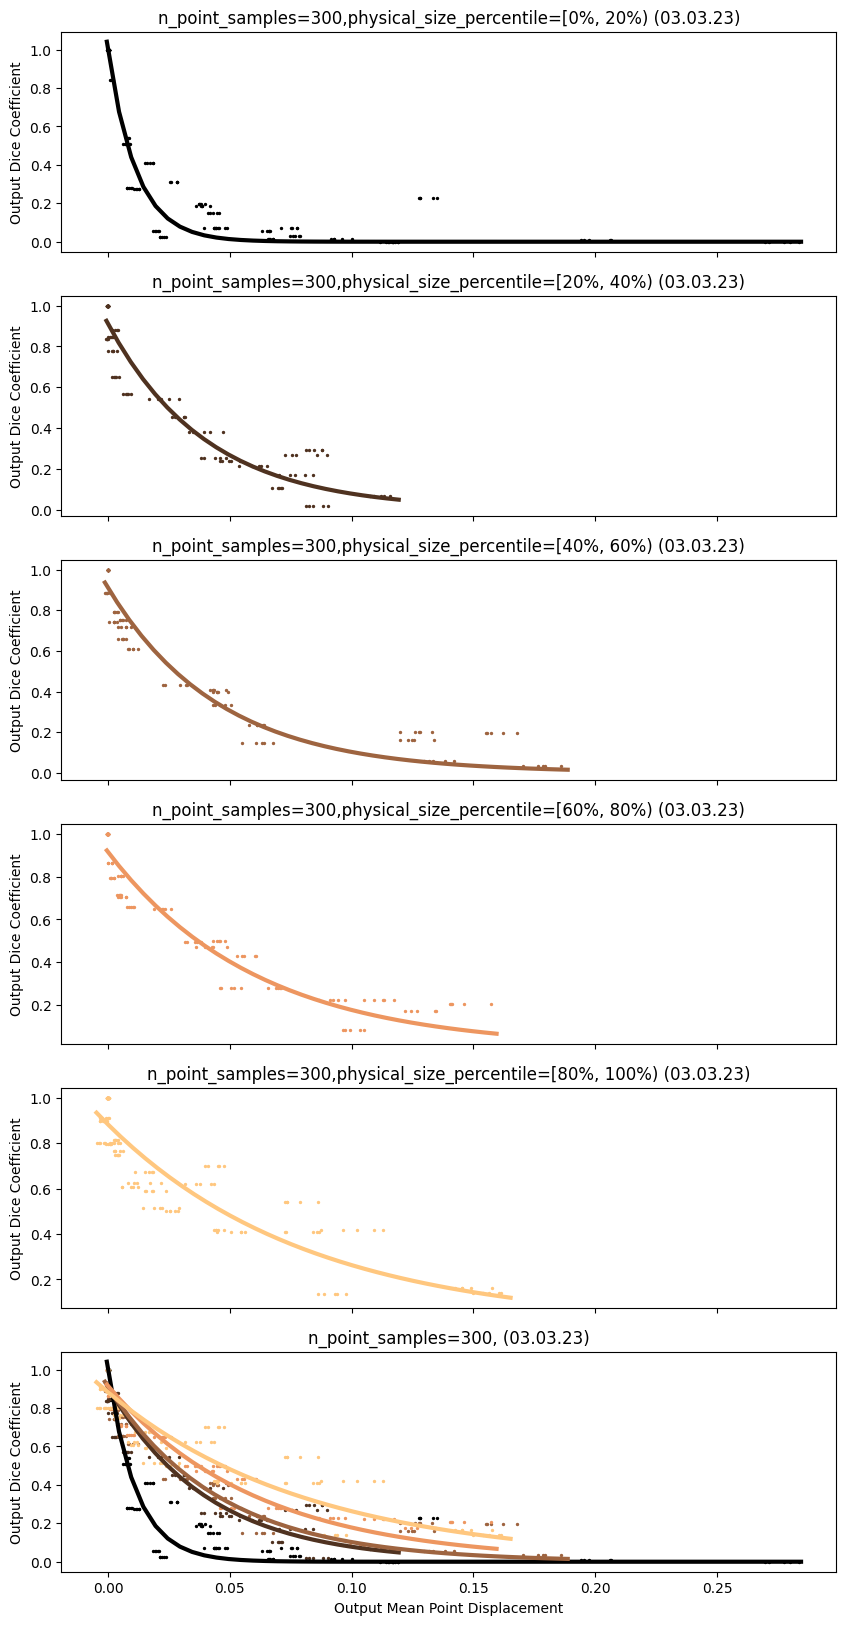

In [118]:
fig, axs = plt.subplots(
    int(100 / PERCENTILE_STEP) + 1, figsize=(10, 20), sharex=True
)

N_POINT_SAMPLES = 300
c = plt.cm.copper(np.linspace(0, 1, int(100 / PERCENTILE_STEP)))
axs[-1].title.set_text(f"n_point_samples={N_POINT_SAMPLES}, ({FILEDATE})")

df_tmp = shape_results_filtered[
    shape_results_filtered["n_point_samples"] == N_POINT_SAMPLES
]
for idx, physical_size_percentile in enumerate(
    np.arange(PERCENTILE_STEP, 101, PERCENTILE_STEP)
):
    df_percentile = df_tmp[
        df_tmp["physical_size_percentile"] == physical_size_percentile
    ]
    print(f"Size: {len(df_percentile)}")
    decay_params = fit_decay(
        df_percentile["output_mean"], df_percentile["output_dice"]
    )

    axs[idx].title.set_text(
        f"n_point_samples={N_POINT_SAMPLES},"
        "physical_size_percentile="
        f"[{physical_size_percentile - PERCENTILE_STEP}%, "
        f"{physical_size_percentile}%) "
        f"({FILEDATE})"
    )
    axs[idx].set_ylabel("Output Dice Coefficient")

    scatter_decay(
        axs[idx],
        df_percentile,
        decay_params,
        point_color=c[idx],
        fit_color=c[idx],
    )
    scatter_decay(
        axs[-1],
        df_percentile,
        decay_params,
        point_color=c[idx],
        fit_color=c[idx],
    )

axs[-1].set_ylabel("Output Dice Coefficient")
axs[-1].set_xlabel("Output Mean Point Displacement")
plt.show()

## Break Down Correlation by Elongation

In [119]:
num_labels = len(np.unique(shape_results_filtered["label_value"]))

elongations = np.unique(shape_results_filtered["elongation"])
print(elongations)
assert len(elongations) == num_labels

[1.03488848 1.32307574 1.67839352 2.15182938 2.17572919 2.21710728
 2.29422229 2.54074324 2.67609862 2.76363803 3.30416592 3.36350111
 3.45012316 3.74394605 4.07398644 5.59591141 9.90100789]


In [120]:
PERCENTILE_STEP = 20
elongation_bins = np.array(
    [
        np.percentile(elongations, p)
        for p in np.arange(PERCENTILE_STEP, 101, PERCENTILE_STEP)
    ]
)
print(elongation_bins)

[2.15660935 2.39283067 3.08795476 3.68518147 9.90100789]


In [121]:
import tqdm

shape_results_filtered["elongation_percentile"] = -1  # initialize
for index in tqdm.tqdm(shape_results_filtered["elongation"].index):
    shape_results_filtered.loc[
        index, "elongation_percentile"
    ] = PERCENTILE_STEP * (
        np.argmax(
            elongation_bins >= shape_results_filtered.loc[index, "elongation"]
        )
        + 1
    )

100%|████████████████████████████████████████████████████████████████████████████| 6120/6120 [00:01<00:00, 4126.66it/s]


In [122]:
shape_results_filtered.tail()

Unnamed: 0 label_value  grid_size  displacement_scale_mm  \
6115        6115         422          7                    0.5   
6116        6116         422          7                    0.5   
6117        6117         422          7                    0.5   
6118        6118         422          7                    0.5   
6119        6119         422          7                    0.5   

      n_point_samples  sampling_seed  output_dice  output_mean  output_stddev  \
6115              300              0     0.161583     0.133775       0.116330   
6116              300              1     0.161583     0.120022       0.112410   
6117              300              2     0.161583     0.125574       0.114621   
6118              300              3     0.161583     0.124772       0.115649   
6119              300              4     0.161583     0.122917       0.117941   

      output_median  ...  physical_size  log10_physical_size  perimeter  \
6115       0.132860  ...        0.06725            -1.172308   1.126317   
6116       0.120075  ...        0.06725            -1.172308   1.126317   
6117       0.124387  ...        0.06725            -1.172308   1.126317   
6118       0.124048  ...        0.06725            -1.172308   1.126317   
6119       0.116441  ...        0.06725            -1.172308   1.126317   

      elongation  flatness roundness equivalent_spherical_radius  \
6115    3.450123  1.498509  0.710044                    0.252271   
6116    3.450123  1.498509  0.710044                    0.252271   
6117    3.450123  1.498509  0.710044                    0.252271   
6118    3.450123  1.498509  0.710044                    0.252271   
6119    3.450123  1.498509  0.710044                    0.252271   

      equivalent_spherical_perimeter  physical_size_percentile  \
6115                        0.799734                        60   
6116                        0.799734                        60   
6117                        0.799734                        60   
6118                        0.799734                        60   
6119                        0.799734                        60   

      elongation_percentile  
6115                     80  
6116                     80  
6117                     80  
6118                     80  
6119                     80  

[5 rows x 27 columns]

In [128]:
# Compute nonlinear correlation for each discrete category of point samples

ssq_elongation_headers = [
    "n_point_samples",
    "elongation_bin_index",
    "elongation_percentile",
    "min_elongation",
    "max_elongation",
    "bin_count",
    "sum_of_squares",
    "avg_sq_residual",
    "stddev_residual",
]
ssq_vals_elongation_df = pd.DataFrame(columns=ssq_elongation_headers)

for n_point_samples in n_point_samples_filtered:
    for bin_index in range(len(elongation_bins)):
        bin_min = elongation_bins[bin_index - 1] if bin_index > 0 else 0
        bin_max = elongation_bins[bin_index]

        df = shape_results_filtered[
            shape_results_filtered["n_point_samples"] == n_point_samples
        ]
        df = df[df["elongation"] > bin_min]
        df = df[df["elongation"] <= bin_max]

        decay_params = fit_decay(df["output_mean"], df["output_dice"])
        ssq = estimate_decay_sum_of_squares(df, decay_params)
        ssq_row = pd.DataFrame(
            [
                [
                    n_point_samples,
                    bin_index,
                    PERCENTILE_STEP * (bin_index + 1),
                    bin_min,
                    bin_max,
                    len(df),
                    ssq,
                    ssq / len(df),
                    np.sqrt(ssq / (len(df) - 2)),
                ]
            ],
            columns=ssq_elongation_headers,
        )

        ssq_vals_elongation_df = pd.concat(
            [ssq_vals_elongation_df, ssq_row], ignore_index=True
        )

ssq_vals_elongation_df.head()

n_point_samples elongation_bin_index elongation_percentile min_elongation  \
0              10                    0                    20              0   
1              10                    1                    40       2.156609   
2              10                    2                    60       2.392831   
3              10                    3                    80       3.087955   
4              10                    4                   100       3.685181   

   max_elongation bin_count  sum_of_squares  avg_sq_residual  stddev_residual  
0        2.156609       160        2.814863         0.017593         0.133475  
1        2.392831       120        4.603974         0.038366         0.197527  
2        3.087955       120        2.800259         0.023335         0.154049  
3        3.685181       120        3.323806         0.027698         0.167833  
4        9.901008       160        6.893493         0.043084         0.208877

In [131]:
# labels = {
#    'n_point_samples': 'Number of Label Region Boundary Points Sampled',
#    'R^2': 'R^2 (Dice and Mean Point Displacement)'
# }
labels["elongation_percentile"] = "Elongation %"

px.line(
    ssq_vals_elongation_df,
    x="n_point_samples",
    y="stddev_residual",
    color="elongation_percentile",
    labels=labels,
    title=f"Regression Fitness by Elongation {FILEDATE}",
)
# title=f'Difference Metric Correlation versus Number of Boundary Point Samples ({FILEDATE})',
# trendline='ols',trendline_options=dict(log_x=True))

## Break Down Correlation By Roundness

In [132]:
num_labels = len(np.unique(shape_results_filtered["label_value"]))

roundnesses = np.unique(shape_results_filtered["roundness"])
print(roundnesses)
assert len(roundnesses) == num_labels

[0.24978602 0.29796804 0.38647629 0.43775422 0.46910423 0.53372927
 0.55334604 0.55841743 0.56259003 0.61071204 0.65420669 0.65745797
 0.71004361 0.71691017 0.73462178 0.73963674 0.97283926]


In [134]:
PERCENTILE_STEP = 20
roundness_bins = np.array(
    [
        np.percentile(roundnesses, p)
        for p in np.arange(PERCENTILE_STEP, 101, PERCENTILE_STEP)
    ]
)
print(roundness_bins)

import tqdm

shape_results_filtered["roundness_percentile"] = -1  # initialize
for index in tqdm.tqdm(shape_results_filtered["roundness"].index):
    shape_results_filtered.loc[
        index, "roundness_percentile"
    ] = PERCENTILE_STEP * (
        np.argmax(
            roundness_bins >= shape_results_filtered.loc[index, "roundness"]
        )
        + 1
    )

shape_results_filtered.tail()

 12%|█████████▋                                                                   | 765/6120 [00:00<00:01, 3891.03it/s]

[0.44402422 0.5553746  0.63680883 0.71553686 0.97283926]


100%|████████████████████████████████████████████████████████████████████████████| 6120/6120 [00:01<00:00, 4154.80it/s]


Unnamed: 0 label_value  grid_size  displacement_scale_mm  \
6115        6115         422          7                    0.5   
6116        6116         422          7                    0.5   
6117        6117         422          7                    0.5   
6118        6118         422          7                    0.5   
6119        6119         422          7                    0.5   

      n_point_samples  sampling_seed  output_dice  output_mean  output_stddev  \
6115              300              0     0.161583     0.133775       0.116330   
6116              300              1     0.161583     0.120022       0.112410   
6117              300              2     0.161583     0.125574       0.114621   
6118              300              3     0.161583     0.124772       0.115649   
6119              300              4     0.161583     0.122917       0.117941   

      output_median  ...  log10_physical_size  perimeter  elongation  \
6115       0.132860  ...            -1.172308   1.126317    3.450123   
6116       0.120075  ...            -1.172308   1.126317    3.450123   
6117       0.124387  ...            -1.172308   1.126317    3.450123   
6118       0.124048  ...            -1.172308   1.126317    3.450123   
6119       0.116441  ...            -1.172308   1.126317    3.450123   

      flatness roundness equivalent_spherical_radius  \
6115  1.498509  0.710044                    0.252271   
6116  1.498509  0.710044                    0.252271   
6117  1.498509  0.710044                    0.252271   
6118  1.498509  0.710044                    0.252271   
6119  1.498509  0.710044                    0.252271   

     equivalent_spherical_perimeter  physical_size_percentile  \
6115                       0.799734                        60   
6116                       0.799734                        60   
6117                       0.799734                        60   
6118                       0.799734                        60   
6119                       0.799734                        60   

      elongation_percentile  roundness_percentile  
6115                     80                    80  
6116                     80                    80  
6117                     80                    80  
6118                     80                    80  
6119                     80                    80  

[5 rows x 28 columns]

In [137]:
# Compute nonlinear correlation for each discrete category of point samples

ssq_roundness_headers = [
    "n_point_samples",
    "roundness_bin_index",
    "roundness_percentile",
    "min_roundness",
    "max_roundness",
    "bin_count",
    "sum_of_squares",
    "avg_sq_residual",
    "stddev_residual",
]
ssq_vals_roundness_df = pd.DataFrame(columns=ssq_roundness_headers)

for n_point_samples in n_point_samples_filtered:
    for bin_index in range(len(roundness_bins)):
        bin_min = roundness_bins[bin_index - 1] if bin_index > 0 else 0
        bin_max = roundness_bins[bin_index]

        df = shape_results_filtered[
            shape_results_filtered["n_point_samples"] == n_point_samples
        ]
        df = df[df["roundness"] > bin_min]
        df = df[df["roundness"] <= bin_max]

        decay_params = fit_decay(df["output_mean"], df["output_dice"])
        ssq = estimate_decay_sum_of_squares(df, decay_params)
        ssq_row = pd.DataFrame(
            [
                [
                    n_point_samples,
                    bin_index,
                    PERCENTILE_STEP * (bin_index + 1),
                    bin_min,
                    bin_max,
                    len(df),
                    ssq,
                    ssq / len(df),
                    np.sqrt(ssq / (len(df) - 2)),
                ]
            ],
            columns=ssq_roundness_headers,
        )

        ssq_vals_roundness_df = pd.concat(
            [ssq_vals_roundness_df, ssq_row], ignore_index=True
        )

ssq_vals_roundness_df.head()

n_point_samples roundness_bin_index roundness_percentile min_roundness  \
0              10                   0                   20             0   
1              10                   1                   40      0.444024   
2              10                   2                   60      0.555375   
3              10                   3                   80      0.636809   
4              10                   4                  100      0.715537   

   max_roundness bin_count  sum_of_squares  avg_sq_residual  stddev_residual  
0       0.444024       160        4.827722         0.030173         0.174800  
1       0.555375       120        3.424307         0.028536         0.170351  
2       0.636809       120        3.710925         0.030924         0.177337  
3       0.715537       120        2.356865         0.019641         0.141327  
4       0.972839       160        4.754842         0.029718         0.173476

In [138]:
# labels = {
#    'n_point_samples': 'Number of Label Region Boundary Points Sampled',
#    'R^2': 'R^2 (Dice and Mean Point Displacement)'
# }
labels["roundness_percentile"] = "Roundness %"

px.line(
    ssq_vals_roundness_df,
    x="n_point_samples",
    y="stddev_residual",
    color="roundness_percentile",
    labels=labels,
    title=f"Regression Fitness by Roundness {FILEDATE}",
)
# title=f'Difference Metric Correlation versus Number of Boundary Point Samples ({FILEDATE})',
# trendline='ols',trendline_options=dict(log_x=True))